In [16]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import vector
import os
vector.register_awkward()
import mplhep
plt.style.use(mplhep.style.CMS)

In [17]:
file = uproot.open("/eos/user/d/ddharmen/updated_cmssw/CMSSW_14_0_0_pre3/src/FastPUPPI/NtupleProducer/python/perfNano_TTbar_PU200.root")
print(file.keys())
data = file["Events"]

['Events;1', 'LuminosityBlocks;1', 'Runs;1', 'MetaData;1', 'ParameterSets;1']


In [18]:
def getBranch(data, l1jet):
    
    # Get list of branches relating to the given jet
    print("Getting list of interesting branches")
    interestingBranches = [branch for branch in data.keys() if l1jet in branch and not f"n{l1jet}" in branch]# and not f"{l1jet}_dau0" in branch] 
    
    # Get only branches corresponding to the desired l1jet
    print("Querying the array with interesting branches")
    l1jetData = data.arrays(interestingBranches)
    
    
    # Get a dictionary relating default branch names to new branch names (ie without leading ak8PuppiJets_...)
    print("Splitting branch names on _ to get renamed fields")
    renamedFields = {field : field.split('_', maxsplit=1)[-1] for field in interestingBranches}

    # Create a new awkward array with the desired l1jet branches and the new branch names
    print("Returning an ak array of the relevant data with the renamed fields")
    arr = ak.Array({renamedFields[field]: l1jetData[field] for field in l1jetData.fields})
    
    
    array_dict = {key: arr[key] for key in arr.fields}
    quarks4mom = ak.zip(array_dict)
    quarks4mom = ak.with_name(quarks4mom, "Momentum4D")
    
    
    return quarks4mom

In [31]:
hsc8Jets_DC = getBranch(data=data, l1jet="HSC9x9SC8DCJets_")
hsc8Jets = getBranch(data=data, l1jet="HSC9x9SC8Jets_")
sc8Jets = getBranch(data=data, l1jet="HSC9x9SC8SCJets_")

Getting list of interesting branches
Querying the array with interesting branches
Splitting branch names on _ to get renamed fields
Returning an ak array of the relevant data with the renamed fields
Getting list of interesting branches
Querying the array with interesting branches
Splitting branch names on _ to get renamed fields
Returning an ak array of the relevant data with the renamed fields
Getting list of interesting branches
Querying the array with interesting branches
Splitting branch names on _ to get renamed fields
Returning an ak array of the relevant data with the renamed fields


In [33]:
num_jets_sc = ak.num(sc8Jets)
num_jets_hsc_dc = ak.num(hsc8Jets_DC)
num_jets_hsc = ak.num(hsc8Jets)

valid_events_sc = num_jets_sc >= 4
valid_events_hsc_dc = num_jets_hsc_dc >= 4
valid_events_hsc = num_jets_hsc >= 4


print(ak.to_list(sc8Jets[:1]))
fourth_jet_sc = sc8Jets[valid_events_sc][:, 3] #fourth jet
fourth_jet_hsc_DC = hsc8Jets_DC[valid_events_hsc_dc][:, 3] #fourth jet
fourth_jet_hsc = hsc8Jets[valid_events_hsc][:, 3] #fourth jet

[[{'pt': 293.75, 'eta': 0.20478643476963043, 'phi': -0.03528155758976936, 'mass': 0.0, 'genpt': 0.0, 'gendr': 99.9000015258789, 'nDau': 16.0}, {'pt': 222.5, 'eta': -0.07439807057380676, 'phi': 2.853971242904663, 'mass': 0.0, 'genpt': 226.36195373535156, 'gendr': 0.007766749709844589, 'nDau': 23.0}, {'pt': 80.0, 'eta': 0.6718835830688477, 'phi': -1.8722236156463623, 'mass': 0.0, 'genpt': 88.12837219238281, 'gendr': 0.04629923775792122, 'nDau': 13.0}, {'pt': 31.25, 'eta': 2.1291654109954834, 'phi': 1.1036992073059082, 'mass': 0.0, 'genpt': 30.557941436767578, 'gendr': 0.11421157419681549, 'nDau': 6.0}, {'pt': 8.5, 'eta': -2.1291654109954834, 'phi': -1.7932236194610596, 'mass': 0.0, 'genpt': 0.0, 'gendr': 99.9000015258789, 'nDau': 2.0}, {'pt': 7.25, 'eta': 0.3014272451400757, 'phi': 0.475534051656723, 'mass': 0.0, 'genpt': 0.0, 'gendr': 99.9000015258789, 'nDau': 2.0}, {'pt': 5.75, 'eta': 0.676485538482666, 'phi': 2.4083499908447266, 'mass': 0.0, 'genpt': 23.83904266357422, 'gendr': 0.0853

In [71]:
fourth_jet_sc.pt
fourth_jet_hsc_DC.pt

<Array [80, 25.2, 61.5, ... 58.8, 42.5, 17.5] type='99942 * float32'>

In [55]:
fixedThresh = 40   #threshold
fourth_jet_genpt = fourth_jet_hsc_DC.genpt
fourth_jet_pt = fourth_jet_hsc_DC.pt
l1_jet4_passedThresh = fourth_jet_pt > fixedThresh

ht_bins = np.linspace(0, 300, 40)       #bins or x-range
bin_centres = (ht_bins[:-1] + ht_bins[1:]) / 2
efficiencies_hsc_DC = []
for binn in range(len(ht_bins) - 1):
    inBinMask = (fourth_jet_genpt >= ht_bins[binn]) & (fourth_jet_genpt < ht_bins[binn + 1])
    
    numerator = ak.sum(l1_jet4_passedThresh[inBinMask])
    denominator = ak.sum(inBinMask)
    
    efficiencies_hsc_DC.append(numerator/denominator)

In [56]:
fourth_jet_genpt = fourth_jet_hsc.genpt
fourth_jet_pt = fourth_jet_hsc.pt
l1_jet4_passedThresh = fourth_jet_pt > fixedThresh

ht_bins = np.linspace(0, 300, 40)       #bins or x-range
bin_centres = (ht_bins[:-1] + ht_bins[1:]) / 2
efficiencies_hsc = []
for binn in range(len(ht_bins) - 1):
    inBinMask = (fourth_jet_genpt >= ht_bins[binn]) & (fourth_jet_genpt < ht_bins[binn + 1])
    
    numerator = ak.sum(l1_jet4_passedThresh[inBinMask])
    denominator = ak.sum(inBinMask)
    
    efficiencies_hsc.append(numerator/denominator)

In [57]:
fourth_jet_genpt = fourth_jet_sc.genpt
fourth_jet_pt = fourth_jet_sc.pt
l1_jet4_passedThresh = fourth_jet_pt > fixedThresh

ht_bins = np.linspace(0, 300, 40)       #bins or x-range
bin_centres = (ht_bins[:-1] + ht_bins[1:]) / 2
efficiencies_sc = []
for binn in range(len(ht_bins) - 1):
    inBinMask = (fourth_jet_genpt >= ht_bins[binn]) & (fourth_jet_genpt < ht_bins[binn + 1])
    
    numerator = ak.sum(l1_jet4_passedThresh[inBinMask])
    denominator = ak.sum(inBinMask)
    
    efficiencies_sc.append(numerator/denominator)

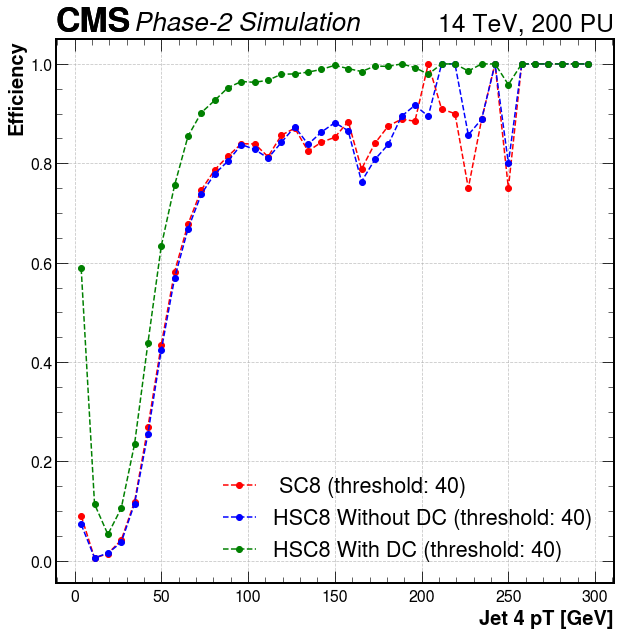

In [69]:
plt.style.use(mplhep.style.ROOT)


# Plotting the efficiencies with matplotlib
plt.plot(bin_centres, efficiencies_sc, marker='o', linestyle='--', color='r', label=f' SC8 (threshold: {fixedThresh})')
plt.plot(bin_centres, efficiencies_hsc, marker='o', linestyle='--', color='b', label=f'HSC8 Without DC (threshold: {fixedThresh})')
plt.plot(bin_centres, efficiencies_hsc_DC, marker='o', linestyle='--', color='g', label=f'HSC8 With DC (threshold: {fixedThresh})')


Jet_n="Jet_4"
# Set axis labels and title
plt.xlabel('Jet 4 pT [GeV]', fontsize=20, fontweight='bold')
plt.ylabel('Efficiency', fontsize=20, fontweight='bold')
plt.title('', fontsize=16)

# Add grid and customize tick marks
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add a legend
plt.legend()
# mplhep.style.use({"font.sans-serif":'Comic Sans MS'})
mplhep.cms.text("Phase-2 Simulation")
# mplhep.cms.text("")
# mplhep.cms.label("Phase-2 Simulation", com= 14, rlabel = "",llabel="")
mplhep.cms.label("",llabel="",rlabel="14 TeV, 200 PU")
# mplhep.cms.text("")
# Show the plot
plt.savefig(f"{Jet_n}_perf.pdf", format="pdf", bbox_inches="tight")
plt.show()